# Profiling Electron-Positron Scattering Processes

Profile $e^- + e^+  \to n (e^- + e^+)$ processes with and without spin combinations.

Make sure that the latest dev versions of QEDprocesses and QEDcore are installed (see `./add_QED_dev.jl`). This is intended for Julia version 1.10, other versions may or may not work.

Depending on your hardware, you might have to adjust the `N` constants in each cell.

In [1]:
using QEDFeynmanDiagrams
using ComputableDAGs
using RuntimeGeneratedFunctions
RuntimeGeneratedFunctions.init(@__MODULE__)
using QEDprocesses
using QEDcore
using DataFrames
using BenchmarkTools

In [2]:
N = 4
pair_prod_df = DataFrame(#
    diagrams=Int[],
    nodes=Int[],
    t_med=Float64[],
    t_std=Float64[],
)

for n in 1:N
    proc_nocombs = ScatteringProcess(
        (Electron(), Positron()),
        (ntuple(_ -> Electron(), n)..., ntuple(_ -> Positron(), n)...),
        (SpinUp(), SpinUp()),
        (ntuple(_ -> SpinUp(), n)..., ntuple(_ -> SpinUp(), n)...),
    )

    graph_gen_bench = @benchmark generate_DAG($proc_nocombs)
    
    g_nocombs = generate_DAG(proc_nocombs)

    push!(pair_prod_df, (length(feynman_diagrams(proc_nocombs)), length(g_nocombs.nodes), median(graph_gen_bench.times), std(graph_gen_bench.times)))
end

N_no_exec = N
pair_prod_df

Row,diagrams,nodes,t_med,t_std
,Int64,Int64,Float64,Float64
1,2,38,42181.0,2.7584e5
2,36,238,1.33398e6,216741.0
3,1728,1402,5.68786e7,1.94327e6
4,158400,8959,2.59134e9,6.29167e7


In [3]:
N = 4
pair_prod_all_sp_df = DataFrame(#
    diagrams=Int[],
    nodes=Int[],
    t_med=Float64[],
    t_std=Float64[],
)

for n in 1:N
    proc_nocombs = ScatteringProcess(
        (Electron(), Positron()),
        (ntuple(_ -> Electron(), n)..., ntuple(_ -> Positron(), n)...),
        (AllSpin(), AllSpin()),
        (ntuple(_ -> AllSpin(), 2*n)...,),
    )

    graph_gen_bench = @benchmark generate_DAG($proc_nocombs)
    
    g_nocombs = generate_DAG(proc_nocombs)

    push!(pair_prod_all_sp_df, (length(feynman_diagrams(proc_nocombs)), length(g_nocombs.nodes), median(graph_gen_bench.times), std(graph_gen_bench.times)))
end

N_no_exec = min(N_no_exec, N)
pair_prod_all_sp_df

Row,diagrams,nodes,t_med,t_std
,Int64,Int64,Float64,Float64
1,2,176,434589.0,1.97256e5
2,36,3316,2.15038e7,1.53647e6
3,1728,118312,1.42751e9,5.62621e7
4,158400,3786085,6.22038e10,NaN


In [4]:
include("../test/utils.jl")

using Random
RNG = MersenneTwister(21)

N = 2
pair_prod_exec_df = DataFrame(#
    diagrams=Int[],
    nodes=Int[],
    t_med=Float64[],
    t_std=Float64[],
)

for n in 1:N
    proc_nocombs = ScatteringProcess(
        (Electron(), Positron()),
        (ntuple(_ -> Electron(), n)..., ntuple(_ -> Positron(), n)...),
        (SpinUp(), SpinUp()),
        (ntuple(_ -> SpinUp(), n)..., ntuple(_ -> SpinUp(), n)...),
    )

    g_nocombs = generate_DAG(proc_nocombs)

    func = get_compute_function(g_nocombs, proc_nocombs, cpu_st(), @__MODULE__)

    psp = gen_process_input(RNG, proc_nocombs)

    exec_bench = @benchmark $func($psp)

    push!(pair_prod_exec_df, (length(feynman_diagrams(proc_nocombs)), length(g_nocombs.nodes), median(exec_bench.times), std(exec_bench.times)))
end

N_exec = N
pair_prod_exec_df

Row,diagrams,nodes,t_med,t_std
,Int64,Int64,Float64,Float64
1,2,38,563.665,64.9958
2,36,238,5243.0,363.538


In [5]:
include("../test/utils.jl")

using Random
RNG = MersenneTwister(21)

N = 2
pair_prod_exec_all_combs_df = DataFrame(#
    diagrams=Int[],
    nodes=Int[],
    t_med=Float64[],
    t_std=Float64[],
)

for n in 1:N
    proc_allcombs = ScatteringProcess(
        (Electron(), Positron()),
        (ntuple(_ -> Electron(), n)..., ntuple(_ -> Positron(), n)...),
        (AllSpin(), AllSpin()),
        (ntuple(_ -> AllSpin(), n)..., ntuple(_ -> AllSpin(), n)...),
    )

    g_allcombs = generate_DAG(proc_allcombs)

    func = get_compute_function(g_allcombs, proc_allcombs, cpu_st(), @__MODULE__)

    psp = gen_process_input(RNG, proc_allcombs)

    exec_bench = @benchmark $func($psp)

    push!(pair_prod_exec_all_combs_df, (length(feynman_diagrams(proc_allcombs)), length(g_allcombs.nodes), median(exec_bench.times), std(exec_bench.times)))
end

N_exec = min(N_exec, N)
pair_prod_exec_all_combs_df

Row,diagrams,nodes,t_med,t_std
,Int64,Int64,Float64,Float64
1,2,176,3796.0,158.621
2,36,3316,117697.0,5941.69


# Plotting

In [6]:
# Colors and Setup
using Plots
using StatsPlots
using Colors
using CurveFit

color1 = parse(RGBA, "#FF1F5B")
color2 = parse(RGBA, "#009ADE")
color3 = parse(RGBA, "#AF58BA")
color4 = parse(RGBA, "#F28522")

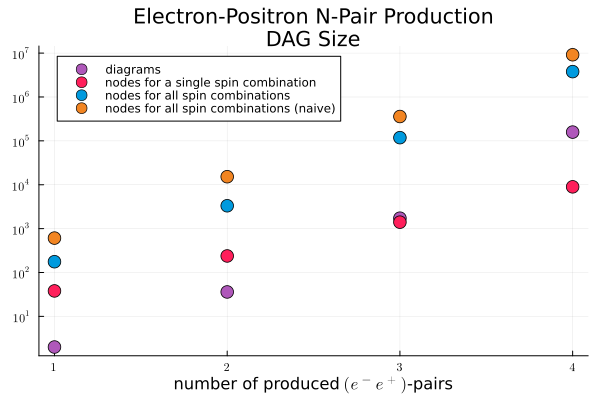

In [30]:
fig = scatter(
    [pair_prod_df.diagrams[1:N_no_exec] pair_prod_df.nodes[1:N_no_exec] pair_prod_all_sp_df.nodes[1:N_no_exec] (pair_prod_df.nodes[1:N_no_exec] .* (2 .^ (4:2:2+(2*N_no_exec))))],
    yscale=:log10,
    seriescolor=[color3 color1 color2 color4],
    label=["diagrams" "nodes for a single spin combination" "nodes for all spin combinations" "nodes for all spin combinations (naive)"],
    title="Electron-Positron N-Pair Production\nDAG Size",
    #ylabel="#",
    xlabel="number of produced \$(e^- e^+)\$-pairs",
    markersize=7,
    legend_position=:topleft,
    #size=(600, 500),
    xticks=([1:N_no_exec...,], ["\$$i\$" for i in 1:N_no_exec]),
    yticks=([(10^i for i in 1:7)...,], ["\$10^$i\$" for i in 1:7])
)
savefig(fig, "pair_prod_dag_size.pdf")
fig

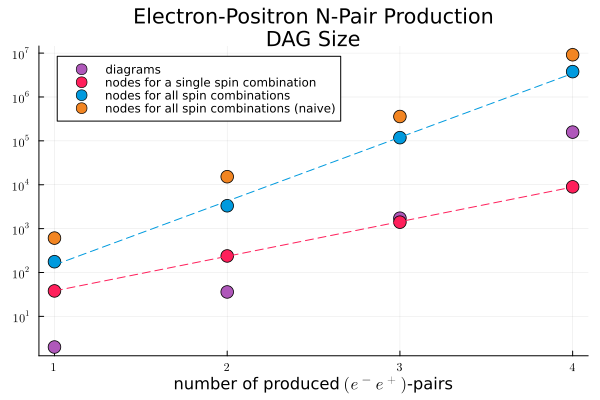

In [31]:
f_nodes_single = curve_fit(ExpFit, Float64.(4:2:(2+2*N_no_exec)), Float64.(pair_prod_df.nodes[1:N_no_exec]))
f_nodes_all = curve_fit(ExpFit, Float64.(4:2:2+(2*N_no_exec)), Float64.(pair_prod_all_sp_df.nodes[1:N_no_exec]))

plot!(fig, 1:0.05:N_no_exec, f_nodes_single.(4:0.1:2+(2*N_no_exec)), seriescolor=color1, label="", linestyle=:dash)
plot!(fig, 1:0.05:N_no_exec, f_nodes_all.(4:0.1:2+(2*N_no_exec)), seriescolor=color2, label="", linestyle=:dash)
savefig(fig, "pair_prod_dag_sizes_expfit.pdf")
fig

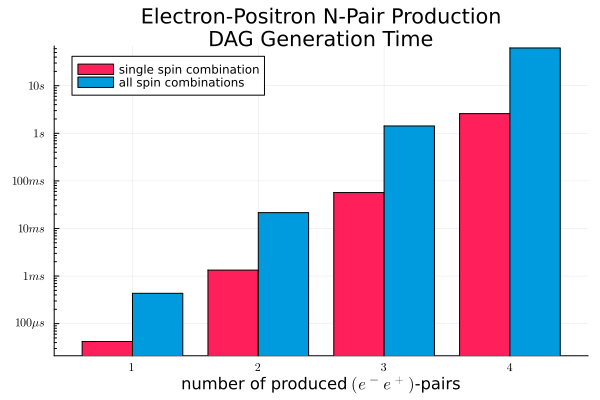

In [32]:
fig = groupedbar(
    ["\$$i\$" for i in 1:N_no_exec],
    [(pair_prod_df.t_med[1:N_no_exec] ./ 1e9) (pair_prod_all_sp_df.t_med[1:N_no_exec] ./ 1e9)],
    #yerr = [(compton_df.t_std ./ 1e9) (compton_all_sp_df.t_std ./ 1e9)],
    seriescolor=[color1 color2],
    title="Electron-Positron N-Pair Production\nDAG Generation Time",
    label=["single spin combination" "all spin combinations"],
    xlabel="number of produced \$(e^- e^+)\$-pairs",
    yticks=([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1],
        ["\$100μs\$", "\$1ms\$", "\$10ms\$", "\$100ms\$", "\$1s\$", "\$10s\$"]),
    yminorticks=true,
    yaxis=:log10, ylim=[0.5 * min(pair_prod_df.t_med[1:N_no_exec]...) / 1e9, 1.1 * max(pair_prod_all_sp_df.t_med[1:N_no_exec]...) / 1e9],
)
savefig(fig, "pair_prod_dag_gen_time.pdf")
fig

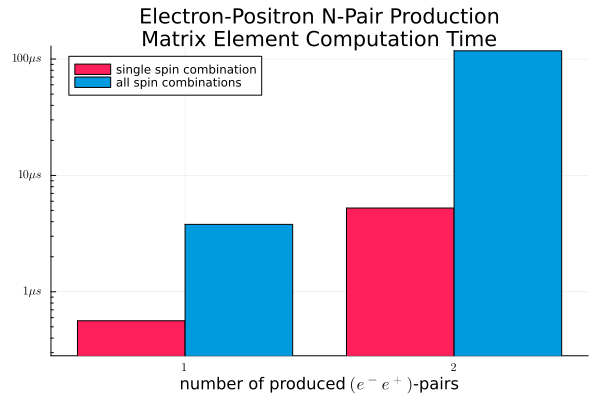

In [33]:
fig = groupedbar(
    ["\$1\$", "\$2\$"],
    [(pair_prod_exec_df.t_med[1:N_exec] ./ 1e9) (pair_prod_exec_all_combs_df.t_med[1:N_exec] ./ 1e9)],
    #yerr = [(compton_exec_df.t_std ./ 1e9) (compton_exec_all_combs_df.t_std ./ 1e9)],
    seriescolor=[color1 color2],
    title="Electron-Positron N-Pair Production\nMatrix Element Computation Time",
    label=["single spin combination" "all spin combinations"],
    xlabel="number of produced \$(e^- e^+)\$-pairs",
    yticks=([1e-6, 1e-5, 1e-4, 1e-3],
        ["\$1μs\$", "\$10μs\$", "\$100μs\$", "\$1ms\$"]),
    yminorticks=true,
    yaxis=:log10,
    ylim=[0.5 * min(pair_prod_exec_df.t_med[1:N_exec]...) / 1e9, 1.1 * max(pair_prod_exec_all_combs_df.t_med[1:N_exec]...) / 1e9],
)
savefig(fig, "pair_prod_exec_time.pdf")
fig